In [1]:
from project_lib import *

def portfolio_nav(trades_pnl, aum = 100000):
    ctrvl_aum = []
    ctrvl_pos = []

    for tr in trades_pnl.keys():
        direction = trades_pnl[tr]['direction'].unique()[0]
        ctrvl_aum.append((trades_pnl[tr]['entry_price'] * trades_pnl[tr]['quantity'] * direction).rename(tr).to_frame())
        
        if direction == 1:
            trades_pnl[tr]['pnl'] = trades_pnl[tr].iloc[:,0] * trades_pnl[tr]['quantity'] * direction
            ctrvl_pos.append((trades_pnl[tr]['pnl']).rename(tr).to_frame())
        elif direction == -1:
            # adj. pnl for short, reverse pnl
            trades_pnl[tr].iloc[:,0] = (trades_pnl[tr].iloc[:,0] - trades_pnl[tr].iloc[0,0]) * (-2) + trades_pnl[tr].iloc[:,0]
            trades_pnl[tr]['pnl'] = trades_pnl[tr].iloc[:,0] * trades_pnl[tr]['quantity'] * direction

            ctrvl_pos.append((trades_pnl[tr]['pnl']).rename(tr).to_frame())

    ctrvl_aum = pd.concat(ctrvl_aum, axis=1).sort_index().ffill().fillna(0)
    ctrvl_pos = pd.concat(ctrvl_pos, axis=1).sort_index().ffill().fillna(0)

    nav = (aum - ctrvl_aum.sum(axis=1) + ctrvl_pos.sum(axis=1))
    
    return nav

In [2]:
DATE_OF_SIMULATION = '2021-04-02'
SIGMA_SL = -1
SIGMA_TP = 1.5
MAX_TRADE_DURATION = 63
PTF_VOL_TGT = 0.15
AUM_LOST_SL = 0.02

In [3]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

In [22]:
def optimal_number_trades(df,
                            incipit_date,
                            sigma_sl,
                            sigma_tp,
                            max_trade_duration, 
                            ptf_vol_tgt,
                            aum_lost_sl):
    """
    Computes the optimal number of trades, given some parameters and simulating random trades based on those parameters

    Parameters:
    - df (pandas.DataFrame): dataset with prices, each column is an instrument
    - incipit_date (str): string with date in format yyyy-mm-dd, it is the date at which we start the simulation. Ideally it is
    the date when the algorithm is run and random trades are generated from incipit_date to incipit_date + 1Y
    - sigma_sl (float): sigma at which SL is triggered. Must be a negative number
    - sigma_tp (float): sigma at which TP is triggered. Must be a positive number
    - max_trade_duration (float): max lenght of a trade expressed in trading days
    - ptf_vol_tgt (float): target volatility of the portfolio
    - aum_lost_sl (float): share of AuM lost from each trade when stopped

    Returns:
    - portfolio_volatility (float): volatility of the portfolio from random trades
    - number_of_trades (float): number of trades)
    """

    # set a generic value of AUM for the portfolio
    aum = 1000000

    if (incipit_date <= '2014-02-12') | (incipit_date >= '2023-02-12'):
        raise ValueError('incipit_date must be between 2014-02-12 and 2023-02-12')
    
    if (sigma_sl >= 0) | (sigma_tp <= 0):
        raise ValueError('sigma_sl must be negative and sigma_tp positive')

    # refill Sat&Sun
    refilled = df.reindex(pd.date_range(df.index.min(), df.index.max()), method='ffill')

    # create list of dates for simulated trades
    date_index_reference = df.loc[pd.to_datetime(incipit_date):pd.to_datetime(incipit_date)+pd.DateOffset(years=1)].index
    startdates = list(date_index_reference.astype(str))

    # create df to store results of the trades
    trades_df = pd.DataFrame()
    ctrvl_aum = pd.DataFrame(index = date_index_reference)
    ctrvl_aum['aum'] = aum
    ctrvl_pos = pd.DataFrame(index = date_index_reference)

    # initialization of portfolio volatility
    portfolio_volatility = 0
    trades_pnl = {}

    # generate random trades until portfolio volatility is below target
    while portfolio_volatility < ptf_vol_tgt:
        security_id = random.choice(list(df.columns))
        trade_entry_date = random.choice(startdates)
        direction = random.choice([-1, 1])

        # compute 5Y Monthly standard deviation starting from date of trade entry and going backward to compute trade's TP/SL
        hist_stdev = refilled.loc[
            refilled.index.isin(pd.date_range(end=trade_entry_date, periods=60+1, freq=pd.DateOffset(months=1))), security_id
                ].pct_change().dropna().std()
        
        # create trade's PnL df
        trade_pnl = df.loc[trade_entry_date:, [security_id]].head(max_trade_duration+1)
        trade_pnl['security_id'] = security_id
        trade_pnl['direction'] = direction
        trade_pnl['hist_volatility'] = hist_stdev
        trade_pnl['entry_price'] = df.loc[trade_entry_date, security_id]
        trade_pnl['tp_price'] = trade_pnl['entry_price'] * (1 + hist_stdev * sigma_tp * direction)
        trade_pnl['sl_price'] = trade_pnl['entry_price'] * (1 + hist_stdev * sigma_sl * direction)
        trade_pnl['quantity'] = (aum * aum_lost_sl) / ((trade_pnl['entry_price'] - trade_pnl['sl_price']) * direction)

        # check if TP/SL have been hitted 
        if direction == 1:
            trade_pnl['tp_hit'] = (trade_pnl[security_id] > trade_pnl['tp_price']) * 1
            trade_pnl['sl_hit'] = (trade_pnl[security_id] < trade_pnl['sl_price']) * 1
        elif direction == -1:
            trade_pnl['tp_hit'] = (trade_pnl[security_id] < trade_pnl['tp_price']) * 1
            trade_pnl['sl_hit'] = (trade_pnl[security_id] > trade_pnl['sl_price']) * 1

        trade_pnl['tp_sl_hit'] = trade_pnl['tp_hit'] + trade_pnl['sl_hit']

        # make exit condition from the trade explicit
        if trade_pnl['tp_sl_hit'].sum()==0:
            trade_pnl['exit_condition'] = 'max_duration'
            trade_pnl['exit_price'] = trade_pnl[security_id].iloc[-1]
        else:
            trade_pnl = trade_pnl.loc[:trade_pnl[trade_pnl['tp_sl_hit'] == 1].index[0]].copy()
            trade_pnl['exit_condition'] = 'stop_loss' if trade_pnl['sl_hit'].sum()==1 else 'take_profit'
            trade_pnl['exit_price'] = trade_pnl['sl_price'] if trade_pnl['sl_hit'].sum()==1 else trade_pnl['tp_price']

        # first day must be subtracted as it is the day when the trade is open
        trade_pnl['duration'] = len(trade_pnl)-1

        # store the trade
        trades_df = pd.concat([trades_df, trade_pnl[['security_id', 'direction', 'hist_volatility', 'entry_price',
            'tp_price', 'sl_price', 'quantity', 'exit_condition', 'exit_price', 'duration']].drop_duplicates()]).sort_index()
        

        #.................. added part ..................
        trades_pnl[f'{trade_entry_date}#{security_id}'] = trade_pnl

        ptf_nav = portfolio_nav(trades_pnl, aum)

        ptf_nav = ptf_nav.reindex(pd.date_range(incipit_date, pd.to_datetime(incipit_date)+pd.DateOffset(years=1), freq='B')).ffill().fillna(aum)

        portfolio_volatility = ptf_nav.pct_change().std() * np.sqrt(252)

    number_of_trades = len(trades_df)
    
    return portfolio_volatility, number_of_trades, ptf_nav

(0.1506597567630935, 28)

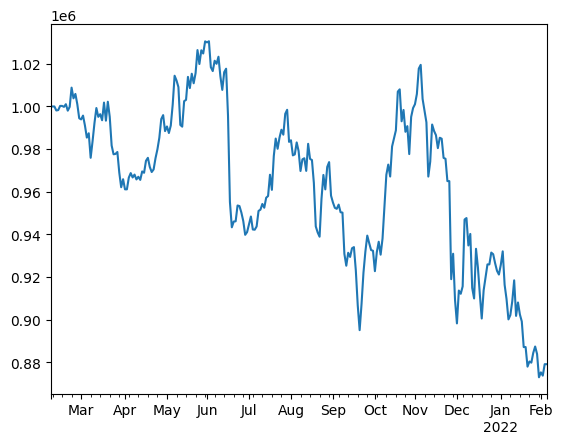

In [21]:
portfolio_volatility, number_of_trades, ptf_nav = optimal_number_trades(df,
            '2021-02-05',
            -1,
            1.5,
            63,
            0.15,
            0.02)

ptf_nav.plot()
portfolio_volatility, number_of_trades
